# Graph Convolutional Network for Time series forecasting

## Problem
* Multivariate time series forecasting
* Algorithm : Graph Convolutional network + Long Short Term Memory (LSTM) https://arxiv.org/pdf/1609.02907.pdf
* Exchange rate data downloaded from: https://www.kaggle.com/brunotly/foreign-exchange-rates-per-dollar-20002019
* The graph in the problem can be treated as discreted time dynamical graph 

![img](image/spatial_temporal_graph.png)

* The model takes as inputs sequences of prices from all exchange rates and adjacency matrixes obtained from the same sequences. 
* The sequences are passed through LSTM layers to capture temporal features, while the adjacency matrixes are processed by GCN layers to extract spatial features (Yu et al., 2017). 
* The model is implemented in Spektral, a library for deep learning built on Tensorflow.

## Practice
1. Import and load data set
2. Visualization
3. Modelling
4. Train model
5. Results


## Import

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import date, timedelta
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

from spektral.layers import GCNConv
from spektral import utils

In [4]:
np.set_printoptions(precision=3)

## Load data set

In [6]:
### READ DATA ###
df = pd.read_csv("Foreign_Exchange_Rates.csv")
df = df.drop(columns=["Unnamed: 0"])
newColumnsNames = list(map(lambda c: c.split(" - ")[0] if "-" in c else "date", df.columns))
df.columns = newColumnsNames
#set date as index
df = df.set_index("date")
df.index = pd.to_datetime(df.index)
#set a daily frequency
df = df.resample('D').asfreq()
# Fill ND values with previous and next values
df = df.replace("ND", np.nan)
df.isnull().values.any()
df = df.ffill().bfill()
#convert to float type
col_list=list(df)
df[col_list[0:]] = df[col_list[0:]].apply(pd.to_numeric, errors='coerce')

In [7]:
df.head()

,AUSTRALIA,EURO AREA,NEW ZEALAND,UNITED KINGDOM,BRAZIL,CANADA,CHINA,HONG KONG,INDIA,KOREA,...,SINGAPORE,DENMARK,JAPAN,MALAYSIA,NORWAY,SWEDEN,SRI LANKA,SWITZERLAND,TAIWAN,THAILAND
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,1.5172,0.9847,1.9033,0.6146,1.8050,1.4465,8.2798,7.7765,43.55,1128.0,...,1.6563,7.3290,101.70,3.8,7.964,8.4430,72.30,1.5808,31.38,36.97
2000-01-04,1.5239,0.9700,1.9238,0.6109,1.8405,1.4518,8.2799,7.7775,43.55,1122.5,...,1.6535,7.2180,103.09,3.8,7.934,8.3600,72.65,1.5565,30.60,37.13
2000-01-05,1.5267,0.9676,1.9339,0.6092,1.8560,1.4518,8.2798,7.7780,43.55,1135.0,...,1.6560,7.2080,103.77,3.8,7.935,8.3530,72.95,1.5526,30.80,37.10
2000-01-06,1.5291,0.9686,1.9436,0.6070,1.8400,1.4571,8.2797,7.7785,43.55,1146.5,...,1.6655,7.2125,105.19,3.8,7.940,8.3675,72.95,1.5540,31.75,37.62
2000-01-07,1.5272,0.9714,1.9380,0.6104,1.8310,1.4505,8.2794,7.7783,43.55,1138.0,...,1.6625,7.2285,105.17,3.8,7.966,8.4150,73.15,1.5623,30.85,37.30


For simplicity, I only choose to model only a set of five exchange rates

In [8]:
subset_columns = list(['AUSTRALIA', 'EURO AREA', 'NEW ZEALAND', 'UNITED KINGDOM', 'CANADA'])
df_subset = df[subset_columns]
df_subset.head()

,AUSTRALIA,EURO AREA,NEW ZEALAND,UNITED KINGDOM,CANADA
date,,,,,
2000-01-03,1.5172,0.9847,1.9033,0.6146,1.4465
2000-01-04,1.5239,0.9700,1.9238,0.6109,1.4518
2000-01-05,1.5267,0.9676,1.9339,0.6092,1.4518
2000-01-06,1.5291,0.9686,1.9436,0.6070,1.4571
2000-01-07,1.5272,0.9714,1.9380,0.6104,1.4505


## Summary statistics

In [10]:
df_subset.describe()

rate,AUSTRALIA,EURO AREA,NEW ZEALAND,UNITED KINGDOM,CANADA
count,7303.000000,7303.000000,7303.000000,7303.000000,7303.000000
mean,1.332301,0.844041,1.543574,0.640733,1.230563
std,0.269719,0.126621,0.336932,0.082632,0.182087
min,0.906900,0.624600,1.134600,0.473800,0.916800
25%,1.115900,0.751100,1.323100,0.587800,1.055850
50%,1.311800,0.815800,1.442800,0.636500,1.237200
75%,1.430600,0.900000,1.589800,0.692300,1.335700
max,2.071300,1.209200,2.551000,0.828700,1.612800


## Visualization

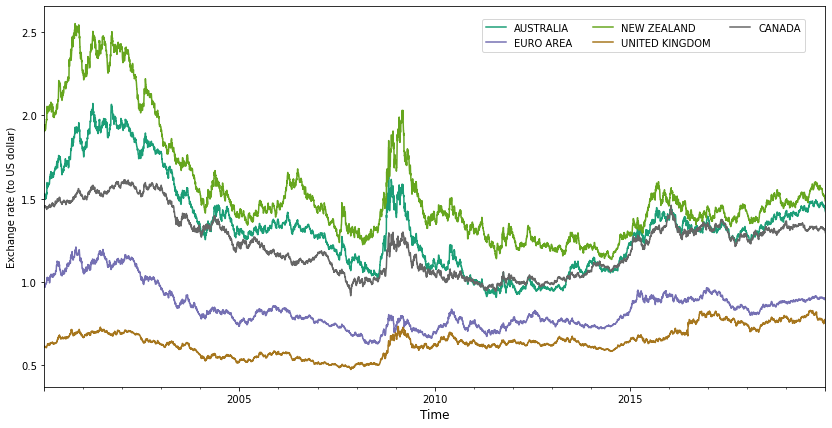

In [14]:
ax = df_subset.plot(colormap='Dark2', figsize=(14,7))
#ax.set_xlabel('Date')
ax.set_ylabel('Exchange rate (to US dollar)')
ax.set_xlabel('Time', fontsize=12)
ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), ncol=3, fontsize=10)
plt.show()

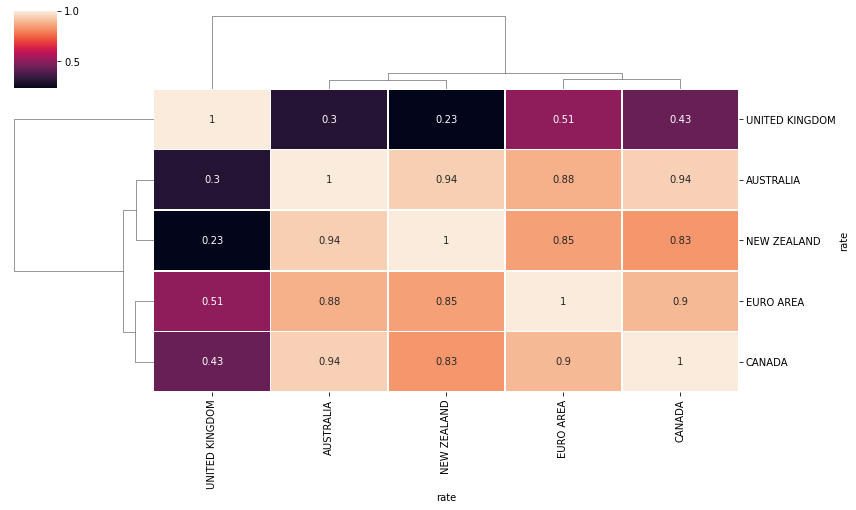

In [17]:
corr = df_subset.corr()
fig = sns.clustermap(corr, annot=True, annot_kws={"size": 10}, linewidths=.4, figsize=(12, 6))
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.show()

## Modelling

In [9]:
### SWITCH DATA FROM VERTICAL TO HORIZONTAL FORMAT ###
data = df_subset.transpose()
data.index.name = 'rate'
data.head()

date,2000-01-03,2000-01-04,2000-01-05,2000-01-06,2000-01-07,2000-01-08,2000-01-09,2000-01-10,2000-01-11,2000-01-12,...,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31
rate,,,,,,,,,,,,,,,,,,,,,
AUSTRALIA,1.5172,1.5239,1.5267,1.5291,1.5272,1.5272,1.5272,1.5242,1.5209,1.5202,...,1.4489,1.4457,1.4445,1.4445,1.4411,1.4331,1.4331,1.4331,1.4278,1.4225
EURO AREA,0.9847,0.9700,0.9676,0.9686,0.9714,0.9714,0.9714,0.9754,0.9688,0.9727,...,0.9029,0.9016,0.9022,0.9022,0.9007,0.8949,0.8949,0.8949,0.8915,0.8907
NEW ZEALAND,1.9033,1.9238,1.9339,1.9436,1.9380,1.9380,1.9380,1.9350,1.9365,1.9286,...,1.5135,1.5088,1.5058,1.5058,1.5002,1.4919,1.4919,1.4919,1.4846,1.4826
UNITED KINGDOM,0.6146,0.6109,0.6092,0.6070,0.6104,0.6104,0.6104,0.6107,0.6068,0.6073,...,0.7671,0.7742,0.7719,0.7719,0.7688,0.7639,0.7639,0.7639,0.7610,0.7536
CANADA,1.4465,1.4518,1.4518,1.4571,1.4505,1.4505,1.4505,1.4568,1.4570,1.4550,...,1.3170,1.3167,1.3160,1.3160,1.3124,1.3073,1.3073,1.3073,1.3058,1.2962


In [33]:
### UTILITY FUNCTIONS FOR FEATURE ENGINEERING ###

sequence_length = 14

def get_timespan(df, today, days):    
    df = df[pd.date_range(today - timedelta(days=days), 
            periods=days, freq='D')] # day - n_days <= dates < day    
    return df

def create_features(df, today, seq_len):
    
    all_sequence = get_timespan(df, today, seq_len).values
    
    group_rate = all_sequence.reshape((-1, 5, seq_len))
    
    rate_corr = np.stack([np.corrcoef(i) for i in group_rate], axis=0)
    
    rate_features = np.stack([
              group_rate.mean(axis=2),
              group_rate.std(axis=2),
              skew(group_rate, axis=2),
              kurtosis(group_rate, axis=2)], axis=1)
    
    group_rate = np.transpose(group_rate, (0,2,1))
    rate_features = np.transpose(rate_features, (0,2,1))
    
    return group_rate, rate_corr, rate_features

def create_label(df, today):
    
    y = df[today].values
    
    return y.reshape((-1, 5))

In [34]:
### DEFINE TRAIN, VALID, TEST DATES ###

train_date = date(2000, 1, 3)
valid_date = date(2014, 1, 1)
test_date = date(2018, 1, 1)

In [35]:
### CREATE TRAIN FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(train_date+timedelta(days=sequence_length), valid_date)):
    seq_, corr_, feat_ = create_features(data, d, sequence_length)
    y_ = create_label(data, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_train_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_train_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_train_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_train = np.concatenate(y, axis=0).astype('float16')

print(X_train_seq.shape, X_train_cor.shape, X_train_feat.shape, y_train.shape)

100%|██████████| 5099/5099 [00:15<00:00, 326.44it/s]


(5099, 14, 5) (5099, 5, 5) (5099, 5, 4) (5099, 5)


In [36]:
### CREATE VALID FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(valid_date+timedelta(days=sequence_length), test_date)):
    seq_, corr_, feat_ = create_features(data, d, sequence_length)
    y_ = create_label(data, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_valid_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_valid_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_valid_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_valid = np.concatenate(y, axis=0).astype('float16')

print(X_valid_seq.shape, X_valid_cor.shape, X_valid_feat.shape, y_valid.shape)

100%|██████████| 1448/1448 [00:04<00:00, 357.54it/s]

(1448, 14, 5) (1448, 5, 5) (1448, 5, 4) (1448, 5)


In [37]:
### CREATE TEST FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(test_date+timedelta(days=sequence_length), date(2019,12,31))):
    seq_, corr_, feat_ = create_features(data, d, sequence_length)
    y_ = create_label(data, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_test_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_test_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_test_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_test = np.concatenate(y, axis=0).astype('float16')

print(X_test_seq.shape, X_test_cor.shape, X_test_feat.shape, y_test.shape)

100%|██████████| 716/716 [00:01<00:00, 376.28it/s]

(716, 14, 5) (716, 5, 5) (716, 5, 4) (716, 5)


In [38]:
### SCALE SEQUENCES ###

scaler_seq = StandardScaler()
scaler_feat = StandardScaler()

X_train_seq = scaler_seq.fit_transform(X_train_seq.reshape(-1,5)).reshape(X_train_seq.shape)
X_valid_seq = scaler_seq.transform(X_valid_seq.reshape(-1,5)).reshape(X_valid_seq.shape)
X_test_seq = scaler_seq.transform(X_test_seq.reshape(-1,5)).reshape(X_test_seq.shape)

y_train = scaler_seq.transform(y_train)
y_valid = scaler_seq.transform(y_valid)
y_test = scaler_seq.transform(y_test)

X_train_feat = scaler_feat.fit_transform(X_train_feat.reshape(-1,5)).reshape(X_train_feat.shape)
X_valid_feat = scaler_feat.transform(X_valid_feat.reshape(-1,5)).reshape(X_valid_feat.shape)
X_test_feat = scaler_feat.transform(X_test_feat.reshape(-1,5)).reshape(X_test_feat.shape)

In [44]:
### OBTAIN NORMALIZED ADJACENCY MATRIX FROM CORRELATIONS ###

X_train_lap = utils.gcn_filter(1 - np.abs(X_train_cor))
X_valid_lap = utils.gcn_filter(1 - np.abs(X_valid_cor))
X_test_lap = utils.gcn_filter(1 - np.abs(X_test_cor))

In [141]:
### GET MODEL ###
def get_model():

    opt = Adam(lr=0.001)

    inp_seq = Input((sequence_length, 5))
    inp_lap = Input((5, 5))
    inp_feat = Input((5, X_train_feat.shape[-1]))

    x = GCNConv(32, activation='relu')([inp_feat, inp_lap])
    x = GCNConv(16, activation='relu')([x, inp_lap]) #repeat the same process except the input is the updated vectors from the first layer
    x = Flatten()(x)

    xx = LSTM(128, activation='relu', return_sequences=True)(inp_seq)
    xx = LSTM(32, activation='relu')(xx)

    x = Concatenate()([x,xx])
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(1)(x)

    model = Model([inp_seq, inp_lap, inp_feat], out)
    model.compile(optimizer=opt, loss='mse', 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [142]:
model = get_model()
model.summary()

Model: "model_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_144 (InputLayer)          [(None, 5, 4)]       0                                            
__________________________________________________________________________________________________
input_143 (InputLayer)          [(None, 5, 5)]       0                                            
__________________________________________________________________________________________________
gcn_conv_94 (GCNConv)           (None, 5, 32)        128         input_144[0][0]                  
                                                                 input_143[0][0]                  
__________________________________________________________________________________________________
input_142 (InputLayer)          [(None, 14, 5)]      0                                     

### Train model

------- rate 0 -------
Epoch 1/100
20/20 - 6s - loss: 0.6098 - root_mean_squared_error: 0.7809 - val_loss: 0.2246 - val_root_mean_squared_error: 0.4739
Epoch 2/100
20/20 - 2s - loss: 0.2572 - root_mean_squared_error: 0.5071 - val_loss: 0.1737 - val_root_mean_squared_error: 0.4168
Epoch 3/100
20/20 - 2s - loss: 0.1974 - root_mean_squared_error: 0.4443 - val_loss: 0.1722 - val_root_mean_squared_error: 0.4149
Epoch 4/100
20/20 - 2s - loss: 0.1595 - root_mean_squared_error: 0.3994 - val_loss: 0.1743 - val_root_mean_squared_error: 0.4174
Epoch 5/100
20/20 - 2s - loss: 0.1433 - root_mean_squared_error: 0.3786 - val_loss: 0.1627 - val_root_mean_squared_error: 0.4033
Epoch 6/100
20/20 - 2s - loss: 0.1287 - root_mean_squared_error: 0.3587 - val_loss: 0.1665 - val_root_mean_squared_error: 0.4081
Epoch 7/100
20/20 - 2s - loss: 0.1258 - root_mean_squared_error: 0.3547 - val_loss: 0.1609 - val_root_mean_squared_error: 0.4012
Epoch 8/100
20/20 - 2s - loss: 0.1102 - root_mean_squared_error: 0.3320 - 

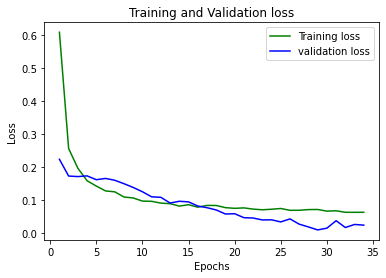

------- rate 1 -------
Epoch 1/100
20/20 - 6s - loss: 0.7972 - root_mean_squared_error: 0.8928 - val_loss: 0.1992 - val_root_mean_squared_error: 0.4463
Epoch 2/100
20/20 - 2s - loss: 0.3077 - root_mean_squared_error: 0.5547 - val_loss: 0.2042 - val_root_mean_squared_error: 0.4519
Epoch 3/100
20/20 - 2s - loss: 0.2141 - root_mean_squared_error: 0.4627 - val_loss: 0.1961 - val_root_mean_squared_error: 0.4429
Epoch 4/100
20/20 - 2s - loss: 0.1763 - root_mean_squared_error: 0.4199 - val_loss: 0.1992 - val_root_mean_squared_error: 0.4463
Epoch 5/100
20/20 - 2s - loss: 0.1586 - root_mean_squared_error: 0.3983 - val_loss: 0.1953 - val_root_mean_squared_error: 0.4419
Epoch 6/100
20/20 - 2s - loss: 0.1369 - root_mean_squared_error: 0.3700 - val_loss: 0.1886 - val_root_mean_squared_error: 0.4343
Epoch 7/100
20/20 - 2s - loss: 0.1298 - root_mean_squared_error: 0.3603 - val_loss: 0.1881 - val_root_mean_squared_error: 0.4337
Epoch 8/100
20/20 - 2s - loss: 0.1193 - root_mean_squared_error: 0.3454 - 

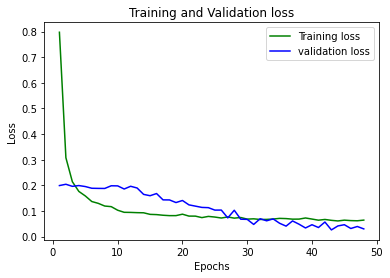

------- rate 2 -------
Epoch 1/100
20/20 - 5s - loss: 0.6212 - root_mean_squared_error: 0.7881 - val_loss: 0.4542 - val_root_mean_squared_error: 0.6739
Epoch 2/100
20/20 - 2s - loss: 0.2648 - root_mean_squared_error: 0.5146 - val_loss: 0.4444 - val_root_mean_squared_error: 0.6667
Epoch 3/100
20/20 - 2s - loss: 0.1964 - root_mean_squared_error: 0.4432 - val_loss: 0.4274 - val_root_mean_squared_error: 0.6537
Epoch 4/100
20/20 - 2s - loss: 0.1634 - root_mean_squared_error: 0.4043 - val_loss: 0.3912 - val_root_mean_squared_error: 0.6255
Epoch 5/100
20/20 - 3s - loss: 0.1488 - root_mean_squared_error: 0.3857 - val_loss: 0.3622 - val_root_mean_squared_error: 0.6018
Epoch 6/100
20/20 - 2s - loss: 0.1300 - root_mean_squared_error: 0.3605 - val_loss: 0.3523 - val_root_mean_squared_error: 0.5936
Epoch 7/100
20/20 - 2s - loss: 0.1275 - root_mean_squared_error: 0.3571 - val_loss: 0.3236 - val_root_mean_squared_error: 0.5688
Epoch 8/100
20/20 - 2s - loss: 0.1143 - root_mean_squared_error: 0.3381 - 

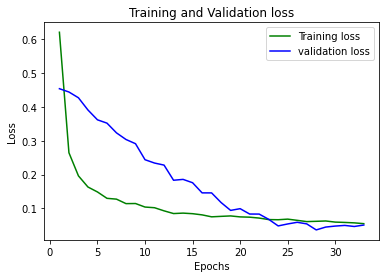

------- rate 3 -------
Epoch 1/100
20/20 - 12s - loss: 1.0511 - root_mean_squared_error: 1.0253 - val_loss: 2.7787 - val_root_mean_squared_error: 1.6670
Epoch 2/100
20/20 - 3s - loss: 0.2897 - root_mean_squared_error: 0.5382 - val_loss: 2.6636 - val_root_mean_squared_error: 1.6321
Epoch 3/100
20/20 - 2s - loss: 0.2167 - root_mean_squared_error: 0.4655 - val_loss: 2.5940 - val_root_mean_squared_error: 1.6106
Epoch 4/100
20/20 - 2s - loss: 0.1844 - root_mean_squared_error: 0.4295 - val_loss: 2.5862 - val_root_mean_squared_error: 1.6082
Epoch 5/100
20/20 - 2s - loss: 0.1689 - root_mean_squared_error: 0.4110 - val_loss: 2.6417 - val_root_mean_squared_error: 1.6253
Epoch 6/100
20/20 - 2s - loss: 0.1570 - root_mean_squared_error: 0.3962 - val_loss: 2.4808 - val_root_mean_squared_error: 1.5750
Epoch 7/100
20/20 - 2s - loss: 0.1519 - root_mean_squared_error: 0.3897 - val_loss: 2.4703 - val_root_mean_squared_error: 1.5717
Epoch 8/100
20/20 - 2s - loss: 0.1358 - root_mean_squared_error: 0.3685 -

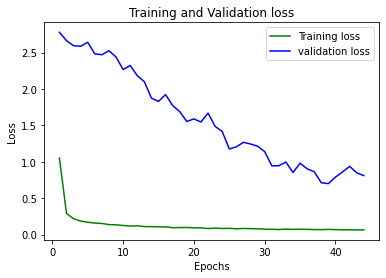

------- rate 4 -------
Epoch 1/100
20/20 - 5s - loss: 0.5859 - root_mean_squared_error: 0.7654 - val_loss: 0.1997 - val_root_mean_squared_error: 0.4469
Epoch 2/100
20/20 - 2s - loss: 0.2581 - root_mean_squared_error: 0.5080 - val_loss: 0.1954 - val_root_mean_squared_error: 0.4421
Epoch 3/100
20/20 - 2s - loss: 0.1745 - root_mean_squared_error: 0.4178 - val_loss: 0.1874 - val_root_mean_squared_error: 0.4329
Epoch 4/100
20/20 - 2s - loss: 0.1649 - root_mean_squared_error: 0.4061 - val_loss: 0.1869 - val_root_mean_squared_error: 0.4323
Epoch 5/100
20/20 - 2s - loss: 0.1361 - root_mean_squared_error: 0.3689 - val_loss: 0.1858 - val_root_mean_squared_error: 0.4311
Epoch 6/100
20/20 - 2s - loss: 0.1234 - root_mean_squared_error: 0.3513 - val_loss: 0.1744 - val_root_mean_squared_error: 0.4177
Epoch 7/100
20/20 - 2s - loss: 0.1254 - root_mean_squared_error: 0.3540 - val_loss: 0.1716 - val_root_mean_squared_error: 0.4143
Epoch 8/100
20/20 - 2s - loss: 0.1119 - root_mean_squared_error: 0.3345 - 

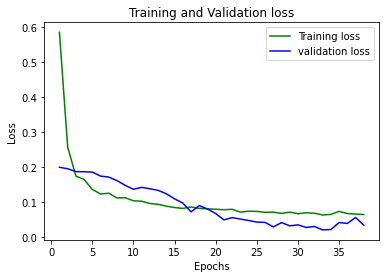

In [143]:
### TRAIN A MODEL FOR EACH RATES USING ALL THE DATA AVAILALBE FROM OTHER RATES ###

tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)



pred_valid_all = np.zeros(y_valid.shape)
pred_test_all = np.zeros(y_test.shape)

for rate in range(5):

    print('-------', 'rate', rate, '-------')
    
    es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

    model = get_model()
    history = model.fit([X_train_seq, X_train_lap, X_train_feat], y_train[:,rate], epochs=100, batch_size=256, 
              validation_data=([X_valid_seq, X_valid_lap, X_valid_feat], y_valid[:,rate]), callbacks=[es], verbose=2)

    pred_valid_all[:,rate] = model.predict([X_valid_seq, X_valid_lap, X_valid_feat]).ravel()
    pred_test_all[:,rate] = model.predict([X_test_seq, X_test_lap, X_test_feat]).ravel()
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(1,len(loss_train) + 1)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

pred_valid_all = scaler_seq.inverse_transform(pred_valid_all)
reverse_valid = scaler_seq.inverse_transform(y_valid)
pred_test_all = scaler_seq.inverse_transform(pred_test_all)
reverse_test = scaler_seq.inverse_transform(y_test)

### Results

In [144]:
### RMSE ON TEST DATA ###

error = {}

for rate in range(5):
    
    error[rate] = np.sqrt(mean_squared_error(reverse_test[:,rate], pred_test_all[:,rate]))

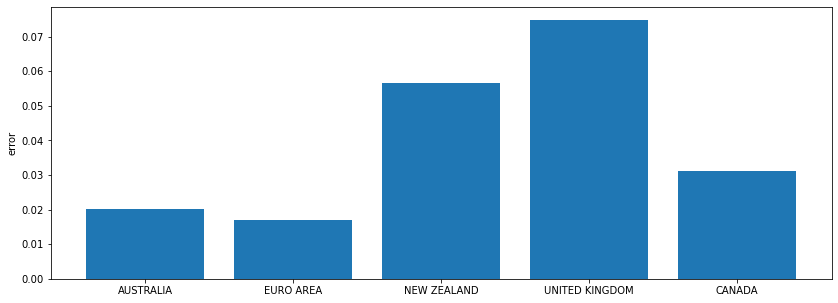

In [145]:
### PLOT RMSE ###

plt.figure(figsize=(14,5))
plt.bar(range(5), error.values())
plt.xticks(range(5), [str(s) for s in subset_columns])
plt.ylabel('error')
np.set_printoptions(False)

In [146]:
### UTILITY FUNCTION TO PLOT PREDICTION ###

def plot_predictions(y_true, y_pred, rate):
    plt.plot(y_true[:,rate], label='true')
    plt.plot(y_pred[:,rate], label='prediction')
    plt.title(str(subset_columns[rate])); plt.legend()
    plt.ylabel('rates'); plt.xlabel('date')

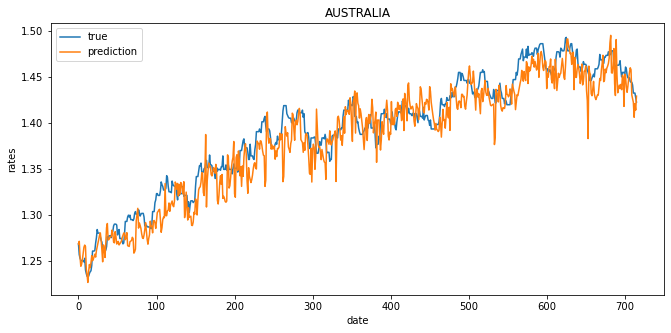

In [147]:
plt.figure(figsize=(11,5))
plot_predictions(reverse_test, pred_test_all, 0)

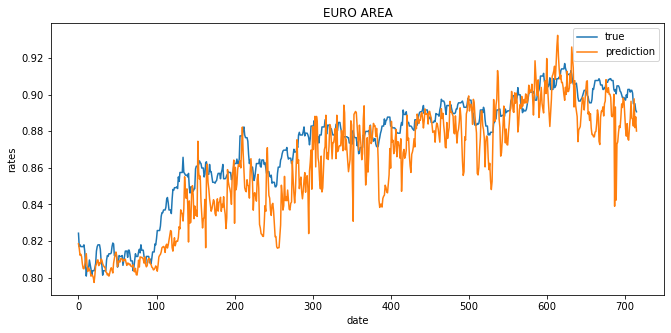

In [148]:
plt.figure(figsize=(11,5))
plot_predictions(reverse_test, pred_test_all, 1)

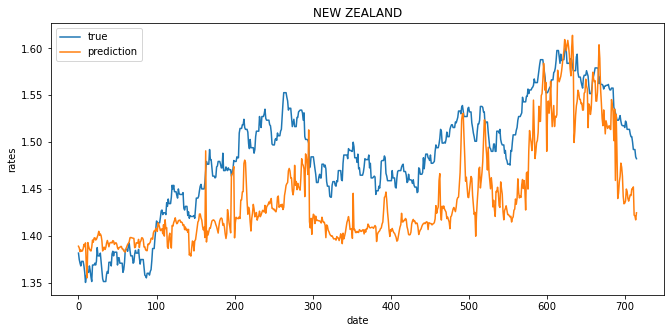

In [149]:
plt.figure(figsize=(11,5))
plot_predictions(reverse_test, pred_test_all, 2)

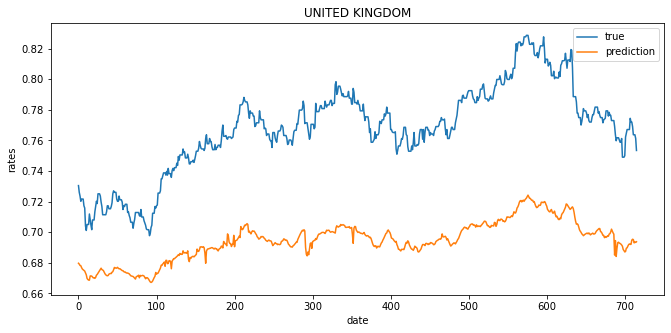

In [150]:
plt.figure(figsize=(11,5))
plot_predictions(reverse_test, pred_test_all, 3)

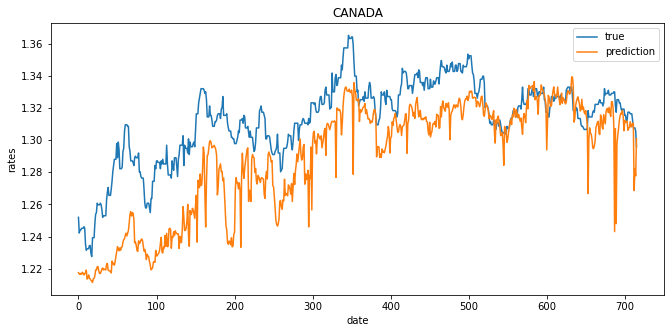

In [151]:
plt.figure(figsize=(11,5))
plot_predictions(reverse_test, pred_test_all, 4)

## Future works
* Use different sequence length, multiple forecast horizons
* Use of different types of correlation
* Find other ways to create matrix representation of graphs
* Use different propagation rules
* Try different scale of data
* Use stationary time series
* Generate different features of nodes
* Hyperparameter tuning

## References
* Kipf, T. N., & Welling, M. (2016). Semi-supervised classification with graph convolutional networks. arXiv preprint arXiv:1609.02907.
* Yu, B., Yin, H., & Zhu, Z. (2017). Spatio-temporal graph convolutional networks: A deep learning framework for traffic forecasting. arXiv preprint arXiv:1709.04875
* https://towardsdatascience.com/time-series-forecasting-with-graph-convolutional-neural-network-7ffb3b70afcf
* https://en.wikipedia.org/wiki/Laplacian_matrix